In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [27]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               907 non-null    object 
 1   SeasonNumber       907 non-null    int64  
 2   SeasonVersion      907 non-null    int64  
 3   Player             907 non-null    object 
 4   MatchId            907 non-null    object 
 5   Map                907 non-null    object 
 6   Category           907 non-null    object 
 7   Playlist           907 non-null    object 
 8   Input              907 non-null    object 
 9   Queue              907 non-null    object 
 10  PreCsr             907 non-null    int64  
 11  PostCsr            907 non-null    int64  
 12  Rank               907 non-null    int64  
 13  WasAtStart         907 non-null    int64  
 14  WasAtEnd           907 non-null    int64  
 15  WasInProgressJoin  907 non-null    int64  
 16  Mmr                2 non-n

In [28]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               643 non-null    int64         
 1   Date                643 non-null    datetime64[ns]
 2   Map                 643 non-null    object        
 3   Category            643 non-null    object        
 4   Rank                643 non-null    int64         
 5   Outcome             643 non-null    int64         
 6   Accuracy            643 non-null    float64       
 7   DamageDone          643 non-null    int64         
 8   DamageTaken         643 non-null    int64         
 9   ShotsFired          643 non-null    int64         
 10  ShotsLanded         643 non-null    int64         
 11  ShotsMissed         643 non-null    int64         
 12  KD                  643 non-null    float64       
 13  KDA                 643 non-null    float64       

In [29]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,643.0,525.272162,222.357313,140.000000,332.500000,525.000000,721.500000,9.060000e+02
Rank,643.0,3.965785,2.156367,1.000000,2.000000,4.000000,5.000000,8.000000e+00
Outcome,643.0,0.553655,0.497500,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Accuracy,643.0,52.165023,5.525448,24.390000,48.700000,52.330000,55.285000,8.056000e+01
DamageDone,643.0,5223.827372,1845.896423,347.000000,3863.500000,5025.000000,6450.500000,1.267300e+04
DamageTaken,643.0,4468.071540,1556.996380,0.000000,3457.500000,4298.000000,5498.500000,9.962000e+03
ShotsFired,643.0,233.866252,80.091697,16.000000,179.000000,226.000000,288.500000,5.170000e+02
ShotsLanded,643.0,121.542768,42.650934,4.000000,94.000000,116.000000,150.000000,2.860000e+02
ShotsMissed,643.0,112.323484,40.881691,7.000000,83.000000,111.000000,138.500000,2.610000e+02
KD,643.0,1.266454,0.760070,0.000000,0.850000,1.120000,1.445000,1.000000e+01


In [30]:
# dfr.tail()
round(dfr.sort_values('Csr', ascending=False),2).head(8)

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
609,869,2024-03-14 01:38:39,Empyrean,CTF 3 Captures,3,1,63.64,1411,910,33,...,1.11,1.16,50.22,28.48,10.10,51.05,7.00,3.38,1105,0.56
606,866,2024-03-14 00:53:15,Live Fire,King of the Hill,1,1,63.01,3826,3956,146,...,1.11,1.16,50.20,28.50,10.09,51.04,7.01,3.37,1103,0.56
611,871,2024-03-15 00:25:24,Solitude,Slayer,4,1,60.38,3498,3318,159,...,1.11,1.16,50.23,28.48,10.10,51.06,6.99,3.37,1099,0.56
608,868,2024-03-14 01:23:44,Argyle,CTF 3 Captures,2,1,63.44,5697,4644,227,...,1.11,1.16,50.22,28.50,10.08,51.06,7.00,3.36,1099,0.56
605,865,2024-03-14 00:39:38,Streets,Oddball,3,1,58.17,6122,5287,251,...,1.11,1.16,50.19,28.48,10.09,51.05,7.01,3.37,1097,0.55
607,867,2024-03-14 01:09:32,Streets,Oddball,8,0,56.62,5543,4668,219,...,1.11,1.16,50.20,28.48,10.09,51.06,7.01,3.37,1093,0.55
610,870,2024-03-14 01:42:56,Argyle,CTF 3 Captures,5,0,51.80,5886,7224,278,...,1.11,1.16,50.22,28.48,10.11,51.05,6.99,3.37,1093,0.55
576,831,2024-03-08 01:52:40,Solitude,Slayer,4,1,40.71,2102,2790,140,...,1.12,1.17,50.02,28.33,10.06,51.10,7.04,3.46,1092,0.55


In [31]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

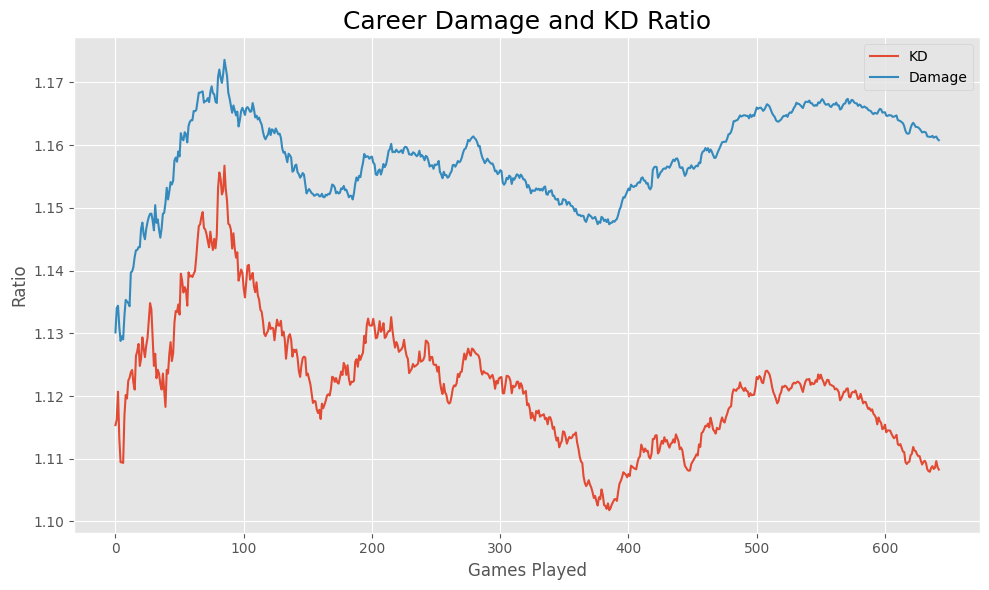

In [32]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

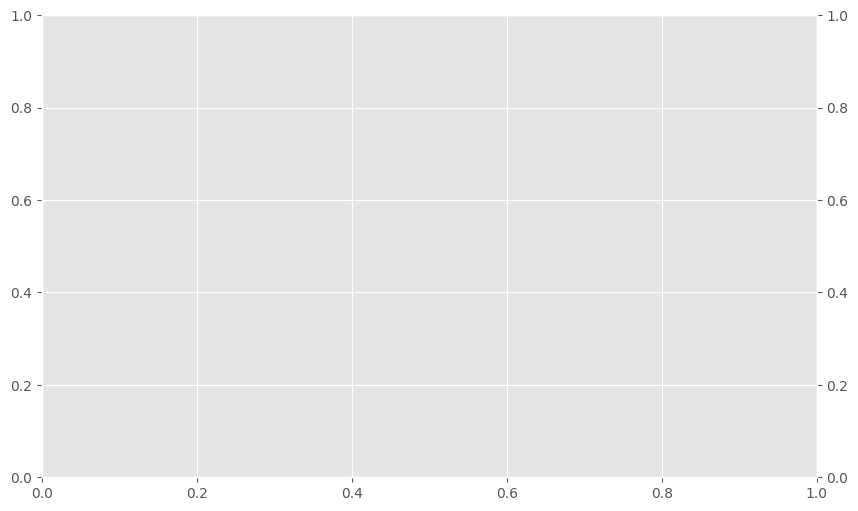

In [33]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

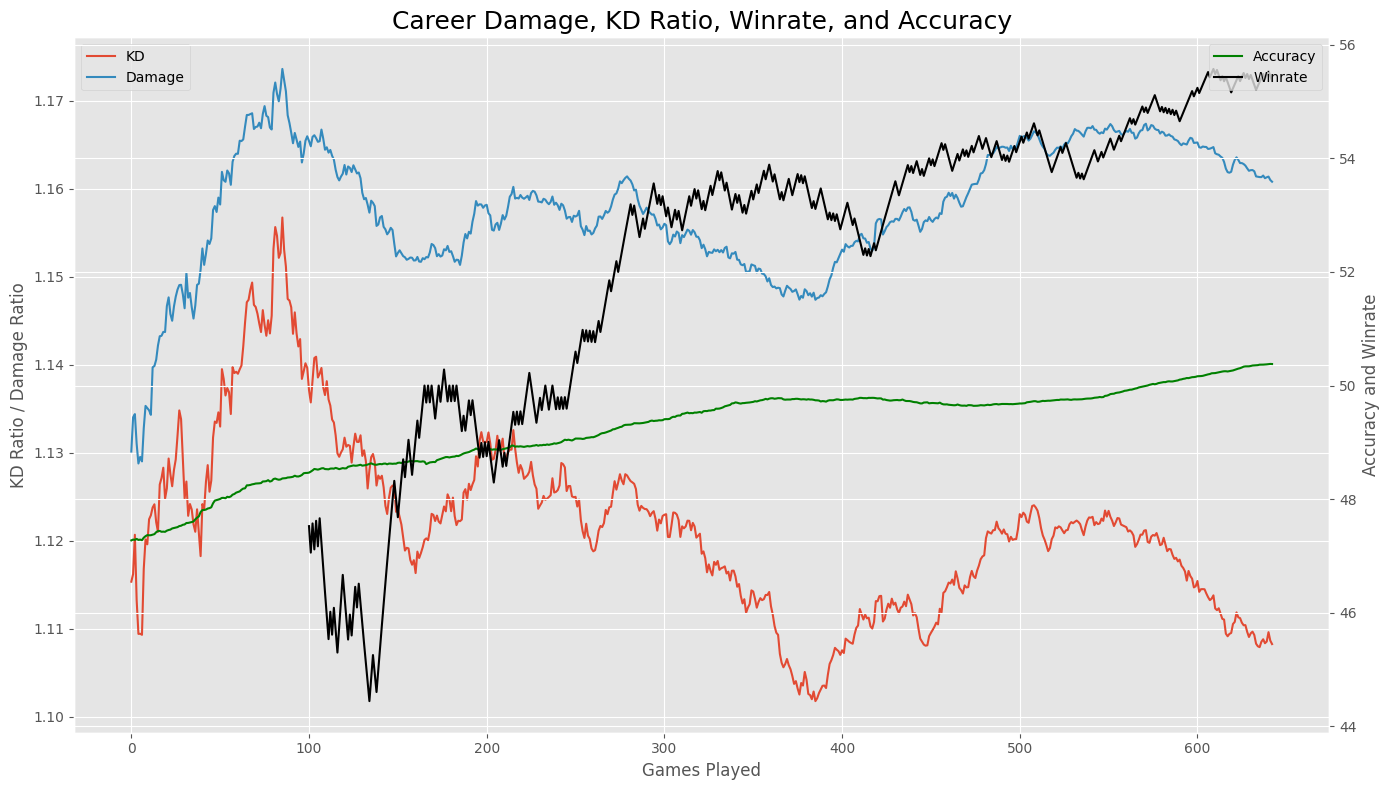

In [34]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

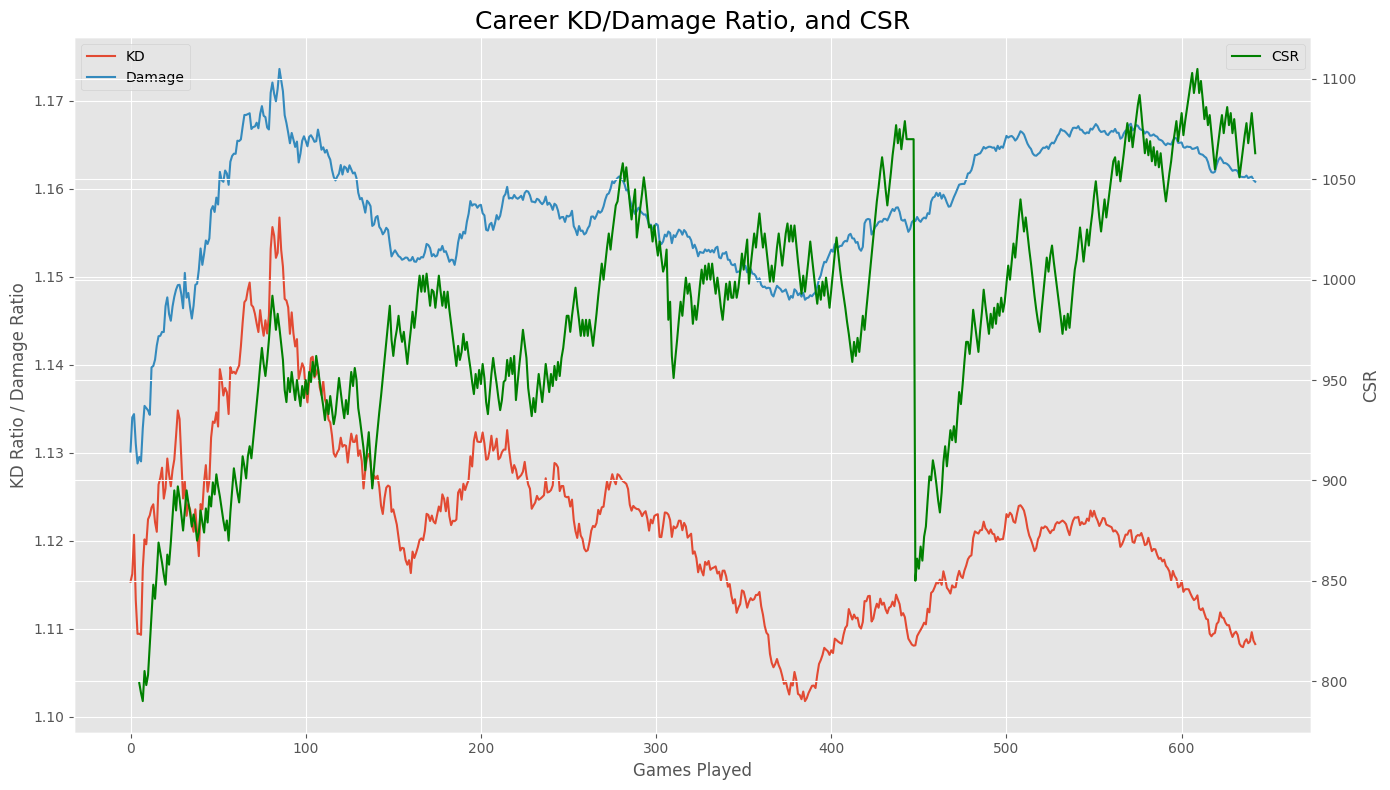

In [35]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

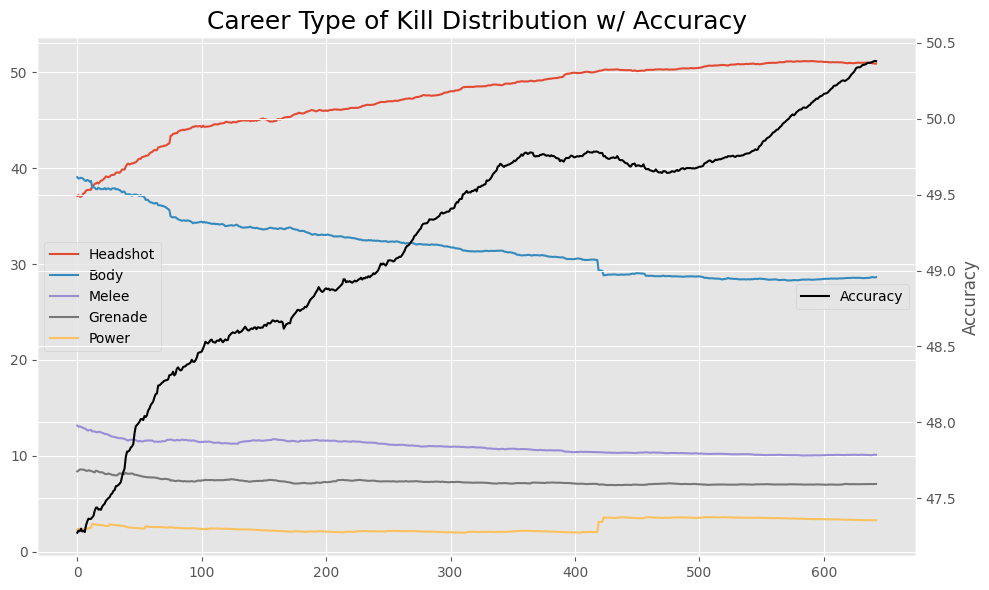

In [36]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

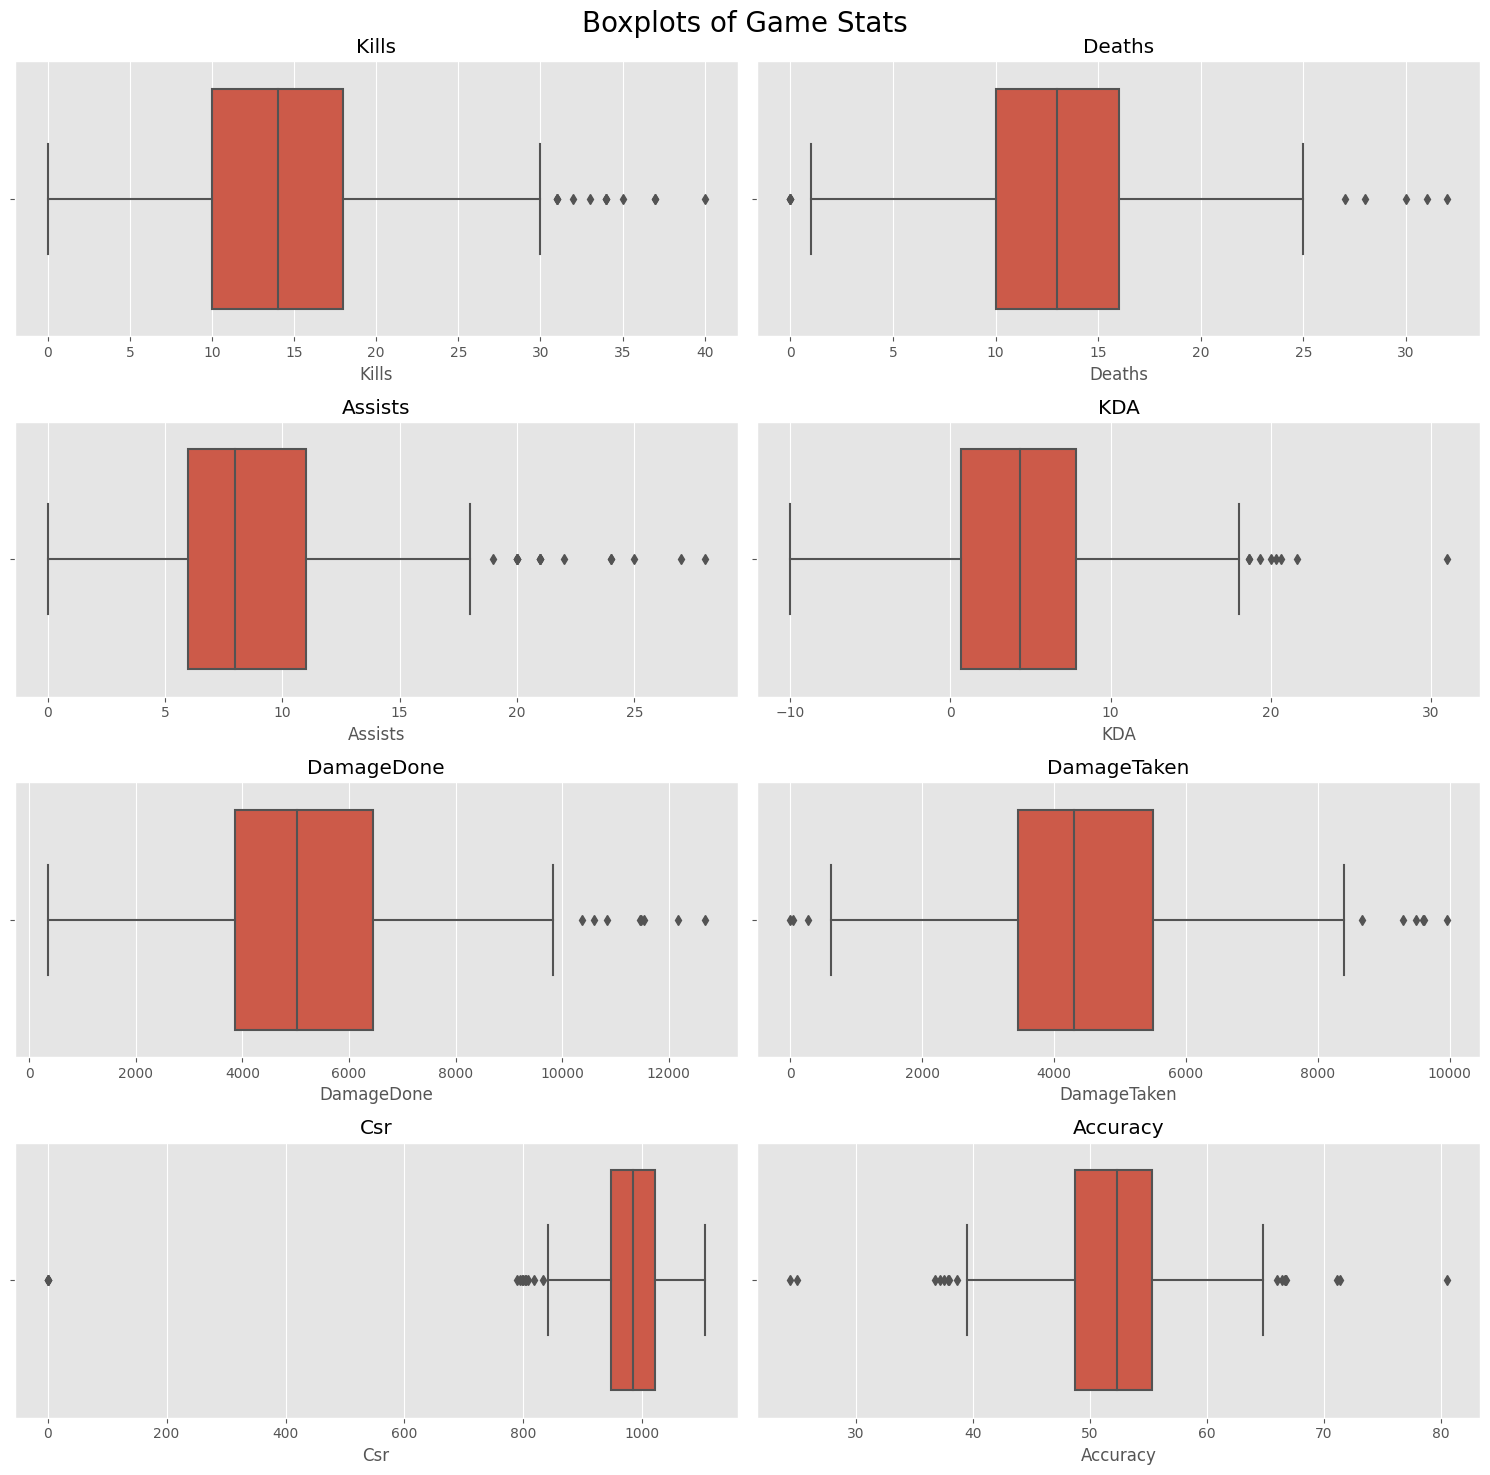

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [38]:
# Last * Games

mod = 10
dfmod = dfr.tail(mod)

# dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 1.07
Accuracy: 53.84
Damage Ratio: 1.08
Win-Loss: 6-4
Winrate: 1.5
Max CSR: 1083


In [39]:
import plotly.express as px

mod = 100

fig = px.line(df, x=df.index, y=df['Accuracy'].rolling(window=mod).mean(), 
              labels={'x': 'Number of Games Played', 'y': 'Accuracy'},
              title='Rolling Avg Accuracy')

fig.show()


In [40]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.14
Average Kills: 13.62
Average Deaths: 11.99
Average Assists: 8.09
Average Accuracy: 51.97
Average Damage Done: 5224
Average Damage Taken: 4468
Damage Ratio: 1.17
Dmg Done <> Taken: 498-145
Win-Loss: 356-287
----------------------------
Totals
Total Games: 643
Total Kills: 9326
Total Deaths: 8284
Total Assists: 5504
----------------------------
Wins
Overall KD: 1.31
Average Kills: 14.11
Average Deaths: 10.75
Average Assists: 8.6
Average Accuracy: 52.38
Average Damage Done: 5079
Average Damage Taken: 4119
Damage Ratio: 1.23
Wins: 356
----------------------------
Losses
Overall KD: 0.96
Average Kills: 13.01
Average Deaths: 13.53
Average Assists: 7.44
Average Accuracy: 51.51
Average Damage Done: 5404
Average Damage Taken: 4902
Damage Ratio: 1.1
Losses: 287


In [41]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 133
Games Ranked 5: 143
MVP %: 42.92


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [42]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
# print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

In [43]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>2].count())
print(gamiPiv[gamiPiv.values>2].sort_values(ascending=False))


Records with >= 3 Scori: 5
Scorigami
15-8-7      3
19-18-10    3
6-11-8      3
7-12-7      3
8-11-5      3
dtype: int64


In [44]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1286.42,150,19.05,23.33
Oddball,1160.87,96,17.19,14.93
CTF 3 Captures,1155.03,105,17.11,16.33
Strongholds,1131.48,97,16.76,15.09
King of the Hill,1009.87,92,14.96,14.31
Extraction,611.85,70,9.06,10.89
CTF,396.80,33,5.88,5.13


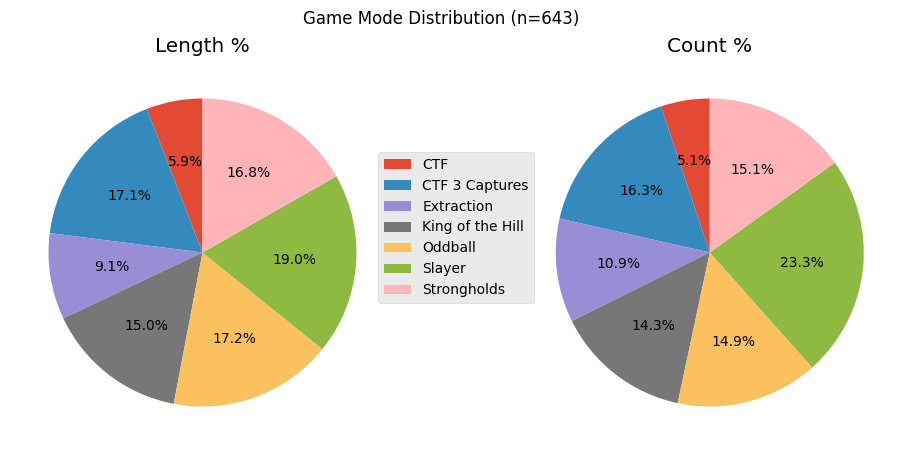

In [45]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [46]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      44         8.93     0.45    6.84     7.94
King of the Hill Recharge      45         8.65     0.51    7.00     7.69
Oddball          Streets       39         7.86     0.64    6.07     6.98
CTF 3 Captures   Argyle        37         7.12     0.49    5.75     6.33
                 Empyrean      36         6.87     0.44    5.60     6.11
CTF              Aquarius      33         6.61     0.48    5.13     5.87
Slayer           Solitude      44         6.46     0.64    6.84     5.74
                 Aquarius      42         5.92     0.55    6.53     5.26
Oddball          Recharge      30         5.91     0.60    4.67     5.25
                 Live Fire     27         5.57     0.59    4.20     4.95
CTF 3 Captures   Forbidden     32         5.26     0.59    4.98     4.67
Strongholds      Recharge      27         5.11     0.44    4.20     4.54
                 Live Fire     26         4.82     0.54    4.04     4.28
Extraction       Streets       33         4.74     0.61    5.13     4.21
King of the Hill Solitude      23         4.36     0.57    3.58     3.87
                 Live Fire     24         3.82     0.79    3.73     3.39
Slayer           Streets       26         3.50     0.62    4.04     3.11
                 Live Fire     24         3.47     0.54    3.73     3.08
Extraction       Recharge      18         2.76     0.61    2.80     2.45
                 Live Fire     19         2.70     0.42    2.95     2.40
Slayer           Recharge      14         2.09     0.57    2.18     1.86

In [47]:
dfrcc = dfr.groupby(['Category','Map']).agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)

dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) * 100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min']
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
dfrcc = round(dfrcc.sort_values(['Winrate', 'Category', 'Map'], ascending=False), 2)
dfrcc

Count  Wins  Losses  Kills  Deaths  Assists  \
Category         Map                                                      
King of the Hill Live Fire     24    19       5    342     321      181   
Oddball          Streets       39    25      14    682     609      420   
Slayer           Solitude      44    28      16    463     467      308   
                 Streets       26    16      10    231     238      176   
Extraction       Recharge      18    11       7    230     193      143   
                 Streets       33    20      13    453     351      253   
Oddball          Recharge      30    18      12    494     412      318   
CTF 3 Captures   Forbidden     32    19      13    415     327      207   
Oddball          Live Fire     27    16      11    434     453      294   
Slayer           Recharge      14     8       6    131     129       96   
King of the Hill Solitude      23    13      10    408     328      239   
Slayer           Aquarius      42    23      19    435     426      275   
                 Live Fire     24    13      11    247     237      141   
Strongholds      Live Fire     26    14      12    414     343      185   
King of the Hill Recharge      45    23      22    786     690      542   
CTF 3 Captures   Argyle        37    18      19    557     480      267   
CTF              Aquarius      33    16      17    622     480      325   
Strongholds      Solitude      44    20      24    819     691      487   
                 Recharge      27    12      15    386     381      246   
CTF 3 Captures   Empyrean      36    16      20    547     512      276   
Extraction       Live Fire     19     8      11    230     216      125   

                            DamageDone  DamageTaken  Winrate  LengthMinutes  \
Category         Map                                                          
King of the Hill Live Fire      116525       105661     0.79         229.30   
Oddball          Streets        240414       204559     0.64         471.75   
Slayer           Solitude       181130       165958     0.64         387.47   
                 Streets         96961        86531     0.62         210.27   
Extraction       Recharge        80159        66596     0.61         165.43   
                 Streets        147191       118482     0.61         284.25   
Oddball          Recharge       178772       146457     0.60         354.85   
CTF 3 Captures   Forbidden      151245       119118     0.59         315.70   
Oddball          Live Fire      165781       145047     0.59         334.27   
Slayer           Recharge        55682        50450     0.57         125.30   
King of the Hill Solitude       138221       112832     0.57         261.75   
Slayer           Aquarius       172796       155049     0.55         355.28   
                 Live Fire       91193        85435     0.54         208.10   
Strongholds      Live Fire      141389       123367     0.54         289.20   
King of the Hill Recharge       283034       237852     0.51         518.82   
CTF 3 Captures   Argyle         198965       167409     0.49         427.28   
CTF              Aquarius       216311       169060     0.48         396.80   
Strongholds      Solitude       278296       234372     0.45         535.97   
                 Recharge       145276       129981     0.44         306.32   
CTF 3 Captures   Empyrean       197217       176403     0.44         412.05   
Extraction       Live Fire       82363        72351     0.42         162.17   

                            Accuracy    KD  DamageRatio  Dmg/Life  Dmg/KA  \
Category         Map                                                        
King of the Hill Live Fire     53.94  1.07         1.10    363.01  222.80   
Oddball          Streets       54.02  1.12         1.18    394.77  218.16   
Slayer           Solitude      50.34  0.99         1.09    387.86  234.93   
                 Streets       49.96  0.97         1.12    407.40  238.23   
Extraction       Recha

In [48]:
dfrcc = dfr.groupby('Category').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,,,,,
Oddball,96,59,37,1610,1474,1032,13233,25198,584967,496063,0.61,1160.87,1.09,1.18,396.86,60.31,0.70
King of the Hill,92,55,37,1536,1339,962,12409,23801,537780,456345,0.60,1009.87,1.15,1.18,401.63,60.82,0.72
Slayer,150,88,62,1507,1497,996,14407,28629,597762,543423,0.59,1286.42,1.01,1.10,399.31,36.30,0.67
Extraction,70,39,31,913,760,521,7421,13807,309713,257429,0.56,611.85,1.20,1.20,407.52,68.79,0.69
CTF 3 Captures,105,53,52,1519,1319,750,12645,24465,547427,462930,0.50,1155.03,1.15,1.18,415.03,64.06,0.57
CTF,33,16,17,622,480,325,5053,9586,216311,169060,0.48,396.80,1.30,1.28,450.65,98.44,0.68
Strongholds,97,46,51,1619,1415,918,12984,24890,564961,487720,0.47,1131.48,1.14,1.16,399.27,54.59,0.65


In [49]:
dfrcc = dfr.groupby('Map').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,,,,,
Streets,98,61,37,1366,1198,849,11503,21634,484566,409572,0.62,966.27,1.14,1.18,404.48,62.60,0.71
Forbidden,32,19,13,415,327,207,3543,6782,151245,119118,0.59,315.70,1.27,1.27,462.52,98.25,0.63
Live Fire,120,70,50,1667,1570,926,13528,25458,597251,531861,0.58,1223.03,1.06,1.12,380.41,41.65,0.59
Solitude,111,61,50,1690,1486,1034,13924,26721,597647,513162,0.55,1185.18,1.14,1.16,402.19,56.85,0.70
Recharge,134,72,62,2027,1805,1345,17326,34381,742923,631336,0.54,1470.72,1.12,1.18,411.59,61.82,0.75
Aquarius,75,39,36,1057,906,600,9226,17717,389107,324109,0.52,752.08,1.17,1.20,429.48,71.74,0.66
Argyle,37,18,19,557,480,267,4574,8934,198965,167409,0.49,427.28,1.16,1.19,414.51,65.74,0.56
Empyrean,36,16,20,547,512,276,4528,8749,197217,176403,0.44,412.05,1.07,1.12,385.19,40.65,0.54


In [50]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 5.378167916991515s
